In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
# from tf.keras.models import Sequential # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

# ModelCheckpoint

In [3]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.utils import to_time_series
from tslearn.utils import to_time_series_dataset
from tslearn.datasets import UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans

In [4]:
from matplotlib import font_manager, rc
import matplotlib

#한글 폰트 등록
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [5]:
# import pandas as pd

# # 판다스 데이터프레임(DataFrame)을 출력할 때, 최대 출력할 수 있는 컬럼을 100개로 늘려줍니다.
# # 이렇게 해야 데이터를 분석할 때 출력해서 확인하기 편합니다.
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [6]:
train = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/test.csv')

In [7]:
weather_time = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/인천_시간별_기상자료.csv',encoding='euc-kr',index_col='일시',parse_dates=True)
del weather_time['지점']

In [8]:
for k in range(1,len(train.columns) ): #시간을 제외한 1열부터 마지막 열까지를 for문으로 작동시킵니다.
    train_median=train.iloc[:,k].median() #값을 대체하는 과정에서 값이 변경 될 것을 대비해 해당 세대의 중앙값을 미리 계산하고 시작합니다.
    counting=train.loc[ train.iloc[:,k].isnull()==False ][ train.columns[k] ].index

    df=pd.DataFrame( list( zip( counting[:-1], counting[1:] - counting[:-1] -1  ) ), columns=['index','count'] )
    
    df2= df[ (df['count'] > 0) ] #결측치가 존재하는 부분만 추출
    df2=df2.reset_index(drop=True) #기존에 존재하는 index를 초기화 하여 이후 for문에 사용함

    for i,j in zip( df2['index'], df2['count'] ) : # i = 해당 세대에서 값이 존재하는 index, j = 현재 index 밑의 결측치 갯수
        if train.iloc[i,k]>=train_median: #현재 index에 존재하는 값이 해당 세대의 중앙 값 이상일때만 분산처리 실행
            train.iloc[ i : i+j+1 , k] = train.iloc[i,k] / (j+1) 
            #현재 index 및 결측치의 갯수 만큼 지정을 하여, 현재 index에 있는 값을 해당 갯수만큼 나누어 줍니다
        else:
            pass
            #현재 index에 존재하는 값이 중앙 값 미만이면 pass를 실행
    if k%50==0: #for문 진행정도 확인용
            print(k,"번째 실행중")

50 번째 실행중
100 번째 실행중
150 번째 실행중
200 번째 실행중
250 번째 실행중
300 번째 실행중
350 번째 실행중
400 번째 실행중
450 번째 실행중
500 번째 실행중
550 번째 실행중
600 번째 실행중
650 번째 실행중
700 번째 실행중
750 번째 실행중
800 번째 실행중
850 번째 실행중
900 번째 실행중
950 번째 실행중
1000 번째 실행중
1050 번째 실행중
1100 번째 실행중
1150 번째 실행중
1200 번째 실행중
1250 번째 실행중
1300 번째 실행중


In [9]:
for k in range(1,len(test.columns) ): #시간을 제외한 1열부터 마지막 열까지를 for문으로 작동시킵니다.
    test_median=test.iloc[:,k].median() #값을 대체하는 과정에서 값이 변경 될 것을 대비해 해당 세대의 중앙값을 미리 계산하고 시작합니다.
    counting=test.loc[ test.iloc[:,k].isnull()==False ][ test.columns[k] ].index

    df=pd.DataFrame( list( zip( counting[:-1], counting[1:] - counting[:-1] -1  ) ), columns=['index','count'] )
    
    df2= df[ (df['count'] > 0) ] #결측치가 존재하는 부분만 추출
    df2=df2.reset_index(drop=True) #기존에 존재하는 index를 초기화 하여 이후 for문에 사용함

    for i,j in zip( df2['index'], df2['count'] ) : # i = 해당 세대에서 값이 존재하는 index, j = 현재 index 밑의 결측치 갯수
        if test.iloc[i,k]>=test_median: #현재 indetestx에 존재하는 값이 해당 세대의 중앙 값 이상일때만 분산처리 실행
            test.iloc[ i : i+j+1 , k] = test.iloc[i,k] / (j+1) 
            #현재 index 및 결측치의 갯수 만큼 지정을 하여, 현재 index에 있는 값을 해당 갯수만큼 나누어 줍니다
        else:
            pass
            #현재 index에 존재하는 값이 중앙 값 미만이면 pass를 실행
    if k%50==0: #for문 진행정도 확인용
            print(k,"번째 실행중")

50 번째 실행중
100 번째 실행중
150 번째 실행중
200 번째 실행중


In [10]:
train['Time'] = train['Time'].apply(pd.to_datetime)
train.set_index('Time',inplace=True)

test['Time'] = test['Time'].apply(pd.to_datetime)
test.set_index('Time',inplace=True)

In [11]:
train_sample = train['2018-02-15':]
train_sample = train_sample.interpolate(method='values')

test_sample = test['2018-02-15':]
test_sample = test_sample.interpolate(method='values')

In [12]:
#결측값 가진 행 제거 - 데이터가 아예 없는 경우
# train_sample.loc[:,train_sample.isnull().sum() >= 1].columns

In [13]:
#결측값 가진 행 제거 - 데이터가 아예 없는 경우
# test_sample.loc[:,test_sample.isnull().sum() >= 1].columns

In [14]:
train_sample.drop(['X4', 'X127', 'X9', 'X65', 'X54', 'X13', 'X53', 'X24', 'X17', 'X14',
       'X48', 'X2', 'X19', 'X36', 'X28', 'X63', 'X38', 'X39', 'X8', 'X64',
       'X29', 'X57', 'X705', 'X71', 'X3', 'X27', 'X22', 'X21', 'X118', 'X6',
       'X45', 'X40', 'X66', 'X52', 'X12', 'X49', 'X1', 'X33', 'X60', 'X46',
       'X963', 'X56', 'X15', 'X11', 'X25', 'X34', 'X23', 'X58'], axis=1, inplace=True)

test_sample.drop(['X26', 'X16', 'X7', 'X18', 'X41', 'X55', 'X5', 'X43', 'X59', 'X10',
       'X62', 'X61', 'X32', 'X31', 'X30', 'X51', 'X35', 'X44', 'X37', 'X42',
       'X50', 'X47', 'X20'],axis=1,inplace=True)

> 입력신호 추가

In [15]:
train_sample['temp'] = weather_time['기온(°C)']['2018-02-15':'2018-06-30'] 
train_sample['temp'] = train_sample['temp'].interpolate(method='values')  # 온도 결측값을 시간에 따른 보간법으로 채움
train_sample['Day'] = train_sample.index.dayofyear
train_sample['Hour'] = train_sample.index.hour


test_sample['temp'] = weather_time['기온(°C)']['2018-02-15':'2018-06-30']
test_sample['temp'] = test_sample.interpolate(method='values')  # 온도 결측값을 시간에 따른 보간법으로 채움
test_sample['Day'] = test_sample.index.dayofyear
test_sample['Hour'] = test_sample.index.hour

In [16]:
train_sample.to_csv('train_sample')
test_sample.to_csv('test_sample')

> Input 형식

>  (전체세대시간, 24시간, 2 )

In [17]:
train_sample = pd.read_csv('train_sample',index_col='Time',parse_dates=True)
test_sample = pd.read_csv('test_sample',index_col='Time',parse_dates=True)

In [18]:
from sklearn.preprocessing import MinMaxScaler

sc_train = MinMaxScaler() # trainSet scaler
sc_test = MinMaxScaler() # testSet scaler
sc_temp = MinMaxScaler() # temp scaler

train_sample_sc = sc_train.fit_transform(train_sample.iloc[:,:-3])
test_sample_sc = sc_test.fit_transform(test_sample.iloc[:,:-3])
temp_sc = sc_temp.fit_transform(train_sample[['temp']])

train_sample_sc = np.concatenate((train_sample_sc, temp_sc), axis=1)
test_sample_sc = np.concatenate((test_sample_sc, temp_sc), axis=1)

In [19]:
train_sample = pd.DataFrame(train_sample_sc, columns=train_sample.columns[:-2],index=train_sample.index)
test_sample = pd.DataFrame(test_sample_sc, columns=test_sample.columns[:-2],index=test_sample.index)

In [20]:
shift_step = 24

In [21]:
tmp_list = [] 
for i in train_sample.columns[:-1]:
    tmp_list.append(train_sample[[i,'temp']].values[:-shift_step].reshape(135,24,2)) 

to_formatted_x = np.array(tmp_list)

In [22]:
res_x = to_formatted_x.reshape(169020,24,2)

res_x.shape

(169020, 24, 2)

In [23]:
for_shifting_y = train_sample.shift(-24)
# for_shifting_y=for_shifting_y.dropna()

tmp_shift_list = []
for i in train_sample.columns[:-1]:
    tmp_shift_list.append(for_shifting_y[i].values[:-shift_step].reshape(135,24,1))

to_formatted_y = np.array(tmp_shift_list)

In [24]:
res_y = to_formatted_y.reshape(169020,24,1)

res_y.shape

(169020, 24, 1)

In [25]:
############################################### TEST DATA #############################################################

In [26]:
tmp_test_list = [] 
for i in test_sample.columns[:-1]:
    tmp_test_list.append(test_sample[[i,'temp']].values[:-shift_step].reshape(135,24,2)) 

to_formatted_test_x = np.array(tmp_test_list)

In [27]:
res_test_x = to_formatted_test_x.reshape(23895,24,2)

res_test_x.shape

(23895, 24, 2)

In [28]:
for_shifting_y = test_sample.shift(-24)

tmp_test_shift_list = []
for i in test_sample.columns[:-1]:
    tmp_test_shift_list.append(for_shifting_y[i].values[:-shift_step].reshape(135,24,1))

to_formatted_test_y = np.array(tmp_test_shift_list)

In [29]:
# to_formatted_test_y.shape

In [30]:
res_test_y = to_formatted_test_y.reshape(23895,24,1)

res_test_y.shape

(23895, 24, 1)

In [31]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 
from keras.layers import TimeDistributed
K.clear_session()

model = Sequential() # Sequeatial Model 
model.add(LSTM(32, input_shape=(24, 2),return_sequences=True)) # (timestep, feature)
model.add(TimeDistributed(Dense(1, activation="linear")))
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 32)            4480      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 24, 1)             33        
Total params: 4,513
Trainable params: 4,513
Non-trainable params: 0
_________________________________________________________________


In [32]:
# 모델 학습
early_stop = EarlyStopping(monitor='loss',patience=7, verbose=1)

history = model.fit(res_x,res_y,epochs=10,batch_size=1024,verbose=1,validation_split=0.2,shuffle=True,callbacks=[early_stop])


Train on 135216 samples, validate on 33804 samples
Epoch 1/10
135216/135216 [==============================] - 19s 138us/step - loss: 0.0187 - val_loss: 0.0145
Epoch 2/10
135216/135216 [==============================] - 17s 128us/step - loss: 0.0142 - val_loss: 0.0134
Epoch 3/10
135216/135216 [==============================] - 17s 126us/step - loss: 0.0134 - val_loss: 0.0128
Epoch 4/10
135216/135216 [==============================] - 17s 127us/step - loss: 0.0129 - val_loss: 0.0125
Epoch 5/10
135216/135216 [==============================] - 17s 127us/step - loss: 0.0127 - val_loss: 0.0123
Epoch 6/10
135216/135216 [==============================] - 17s 127us/step - loss: 0.0125 - val_loss: 0.0122
Epoch 7/10
135216/135216 [==============================] - 17s 126us/step - loss: 0.0124 - val_loss: 0.0121
Epoch 8/10
135216/135216 [==============================] - 17s 125us/step - loss: 0.0123 - val_loss: 0.0121
Epoch 9/10
135216/135216 [==============================] - 16s 121us/step -

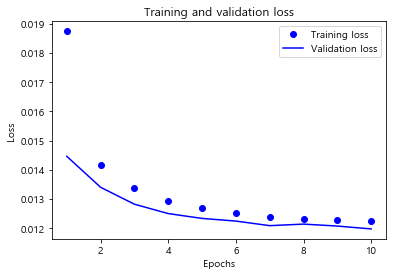

In [33]:
history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')# ‘bo’는 파란색 점
plt.plot(epochs, val_loss, 'b', label='Validation loss')# ‘b’는 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
pred = model.predict(res_test_x)

In [35]:
## to inverse minmax scale

col_list = test_sample.columns.insert(0,'임시')
tt_index = test_sample[:'2018-06-29-23:00:00'].index

test_inverse_df = pd.DataFrame()

for i in range(1,len(test_sample.columns)):# temp col 제외
    tmp = i*3240
    tt = pred.reshape(573480,1)[tmp-3240:tmp]    
    test_inverse_df[col_list[i]] = tt.reshape(3240,)
    
test_inverse_df = test_inverse_df.set_index(tt_index)
test_inverse_df_array = sc_test.inverse_transform(test_inverse_df)

In [36]:
# inverse minmax scale DataFrame 

res_test_df = pd.DataFrame(test_inverse_df_array, columns=test_inverse_df.columns,index=tt_index)

In [37]:
# 예측한 결과물 DataFrame
# res_test_df

In [38]:
# 결과물과 원본 DataFrame 모두 inverse scaling 

In [39]:
test_none_scale = pd.read_csv('test_sample',index_col='Time',parse_dates=True)

In [40]:
test_none_scale = test_none_scale.loc[:,:'X230'].shift(-24).dropna()

> 결과 체크

In [41]:
test_sample.columns

Index(['X303', 'X241', 'X435', 'X402', 'X352', 'X305', 'X350', 'X326', 'X299',
       'X160',
       ...
       'X283', 'X329', 'X223', 'X266', 'X443', 'X347', 'X75', 'X107', 'X230',
       'temp'],
      dtype='object', length=178)

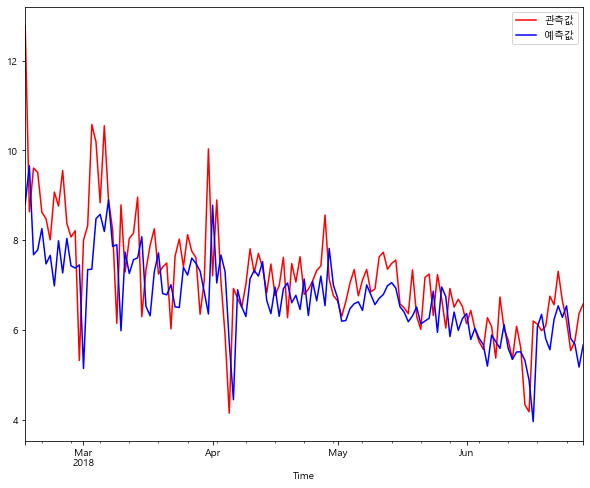

In [42]:
# 일별

test_none_scale['X241'].resample('D').sum().plot(figsize=(10,8),color='red',label='관측값')
res_test_df['X241'].resample('D').sum().plot(figsize=(10,8),color='blue',label='예측값')
plt.legend()

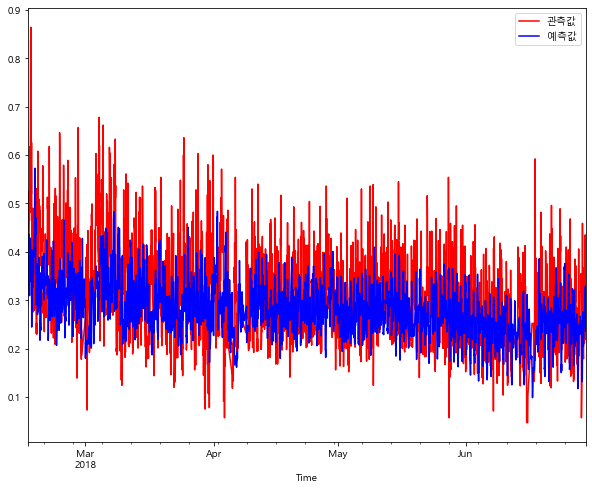

In [43]:
# 시간별 

test_none_scale['X241'].plot(figsize=(10,8),color='red',label='관측값')
res_test_df['X241'].plot(figsize=(10,8),color='blue',label='예측값')
plt.legend()